#NOTEBOOK BELONGS TO :
- GYANIG KUMAR
- GAURAV MAYAL
- UTKARSH KUMAR
- ANSH 

##FEW APPROACH DETAILS
The model is based on using the convolutional neural networks, using the embedding and GloVE from NLP. The TITLE is considered to be the main set of words for accuracy. We tried creating a column with all the texts with individually cleaning and remving stopewords and even tried stemming and leximization of the text. But this approach proved to be efficient with right set of words defined. The BRAND column could be considered important also in somecases. 
- we considered mini batch implementations and using automatic learning_rate with the optimizer - adam
- sparse categorial classifier seemed to work better than any other ML classifier

##STACK
- the code was designed using google colab pro using a GPU acceleration
- TF2 as backend
- sklearn as label encoder 


import all the requirements

In [1]:
import numpy as np
import csv
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam#Try all of these
from sklearn.preprocessing import LabelEncoder

print(tf.__version__)

2.5.0


using wget and unzip

In [2]:
!wget "https://s3-ap-southeast-1.amazonaws.com/he-public-data/dataset52a7b21.zip"
!unzip dataset52a7b21.zip

--2021-08-01 18:01:32--  https://s3-ap-southeast-1.amazonaws.com/he-public-data/dataset52a7b21.zip
Resolving s3-ap-southeast-1.amazonaws.com (s3-ap-southeast-1.amazonaws.com)... 52.219.125.74
Connecting to s3-ap-southeast-1.amazonaws.com (s3-ap-southeast-1.amazonaws.com)|52.219.125.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1061576029 (1012M) [binary/octet-stream]
Saving to: ‘dataset52a7b21.zip.1’

dataset52a7b21.zip. 100%[===================>]   1012M  14.2MB/s    in 75s     

2021-08-01 18:02:48 (13.5 MB/s) - ‘dataset52a7b21.zip.1’ saved [1061576029/1061576029]

Archive:  dataset52a7b21.zip
replace dataset/train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: dataset/train.csv       
  inflating: dataset/sample_submission.csv  
  inflating: dataset/test.csv        
  inflating: dataset/.~lock.train.csv#  


In [ ]:
#len(train_df)=2903024

declaring dataframe and cleaning the data

In [2]:
train_df=pd.read_csv('dataset/train.csv',escapechar = "\\",quoting = csv.QUOTE_NONE)

In [3]:
train_df.fillna("",inplace=True)


In [5]:
train_df

,TITLE,DESCRIPTION,BULLET_POINTS,BRAND,BROWSE_NODE_ID
0,"Pete The Cat Bedtime Blues Doll, 14.5 Inch","Pete the Cat is the coolest, most popular cat ...","[Pete the Cat Bedtime Blues plush doll,Based o...",MerryMakers,0
1,"The New Yorker NYHM014 Refrigerator Magnet, 2 ...",The New Yorker Handsome Cello Wrapped Hard Mag...,[Cat In A Tea Cup by New Yorker cover artist G...,The New Yorker,1
2,The Ultimate Self-Sufficiency Handbook: A Comp...,,Skyhorse Publishing,imusti,2
3,Amway Nutrilite Kids Chewable Iron Tablets (100),,"[Nutrilite Kids,Chewable Iron Tablets,Quantity...",Amway,3
4,Teacher Planner Company A4 6 Lesson Academic T...,,,,4
...,...,...,...,...,...
2903019,Premium Aviator Sunglasses - HD Polarized (Bri...,These premium Aviator Sunglasses with 5 color ...,"[Frame size: Lens height - 56mm, Lens width - ...",Generic,1040
2903020,Social Distance Stickers - Set of 5 Sticker Sl...,set of 5 prints social distancing sticker self...,[covid19 safety sticker - set of 5 to maintain...,Generic,15199
2903021,Torr-to Face Shield PACK OF 5 with Adjustable ...,* COMPLETE FACE PROTECTION: Torr-to Face Shiel...,"[350 MICRONS PACK OF 5 PCS,COMPLETE FACE PROTE...",TORR-TO,1044933
2903022,Type-C to 3.5 MM for Oppo R17 Pro Type-C to 3....,Still want to use your favorite earphones/head...,"[Indian Connectors: Made for Indian sockets, t...",SHOPBELL,14790


In [5]:
import nltk
from nltk.tokenize import sent_tokenize,word_tokenize
nltk.download('punkt') 

import re
from nltk.corpus import stopwords
nltk.download('stopwords')
import string

stop_words = stopwords.words('english')
more = ['mm', 'cm', 'x', 'inch', 'inches', 'millimeter', 'centimeter']
stop_words = stop_words + more

def cleaning(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)

    return text

def sw_rem(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text

train_df['TITLE']=train_df['TITLE'].apply(cleaning)
train_df

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,TITLE,DESCRIPTION,BULLET_POINTS,BRAND,BROWSE_NODE_ID
0,pete the cat bedtime blues doll inch,"Pete the Cat is the coolest, most popular cat ...","[Pete the Cat Bedtime Blues plush doll,Based o...",MerryMakers,0
1,the new yorker refrigerator magnet x,The New Yorker Handsome Cello Wrapped Hard Mag...,[Cat In A Tea Cup by New Yorker cover artist G...,The New Yorker,1
2,the ultimate selfsufficiency handbook a comple...,,Skyhorse Publishing,imusti,2
3,amway nutrilite kids chewable iron tablets,,"[Nutrilite Kids,Chewable Iron Tablets,Quantity...",Amway,3
4,teacher planner company lesson academic teac...,,,,4
...,...,...,...,...,...
2903019,premium aviator sunglasses hd polarized brigh...,These premium Aviator Sunglasses with 5 color ...,"[Frame size: Lens height - 56mm, Lens width - ...",Generic,1040
2903020,social distance stickers set of sticker slip...,set of 5 prints social distancing sticker self...,[covid19 safety sticker - set of 5 to maintain...,Generic,15199
2903021,torrto face shield pack of with adjustable el...,* COMPLETE FACE PROTECTION: Torr-to Face Shiel...,"[350 MICRONS PACK OF 5 PCS,COMPLETE FACE PROTE...",TORR-TO,1044933
2903022,typec to mm for oppo pro typec to mm audio ...,Still want to use your favorite earphones/head...,"[Indian Connectors: Made for Indian sockets, t...",SHOPBELL,14790


In [6]:
train_df['TITLE']= train_df['TITLE']+ " " + train_df['BRAND']

In [7]:
train_df['BULLET_POINTS']= train_df['BULLET_POINTS'].apply(sw_rem)

In [8]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    # text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
train_df['BULLET_POINTS'] = train_df['BULLET_POINTS'].apply(clean_text)
train_df['BULLET_POINTS'] = train_df['BULLET_POINTS'].str.replace('\d+', '')

In [9]:
train_df['TITLE']= train_df['TITLE']+ " " + train_df['BULLET_POINTS']

In [10]:
train_df

,TITLE,DESCRIPTION,BULLET_POINTS,BRAND,BROWSE_NODE_ID
0,pete the cat bedtime blues doll inch MerryMak...,"Pete the Cat is the coolest, most popular cat ...",pete cat bedtime blues plush doll based popul...,MerryMakers,0
1,the new yorker refrigerator magnet x The Ne...,The New Yorker Handsome Cello Wrapped Hard Mag...,cat in a tea cup new yorker cover artist gurb...,The New Yorker,1
2,the ultimate selfsufficiency handbook a comple...,,skyhorse publishing,imusti,2
3,amway nutrilite kids chewable iron tablets Am...,,nutrilite kids chewable iron tablets quantity...,Amway,3
4,teacher planner company lesson academic teac...,,,,4
...,...,...,...,...,...
2903019,premium aviator sunglasses hd polarized brigh...,These premium Aviator Sunglasses with 5 color ...,frame size lens height mm lens width mm ...,Generic,1040
2903020,social distance stickers set of sticker slip...,set of 5 prints social distancing sticker self...,covid safety sticker set maintain crowd con...,Generic,15199
2903021,torrto face shield pack of with adjustable el...,* COMPLETE FACE PROTECTION: Torr-to Face Shiel...,microns pack of pcs complete face protectio...,TORR-TO,1044933
2903022,typec to mm for oppo pro typec to mm audio ...,Still want to use your favorite earphones/head...,indian connectors made indian sockets wall c...,SHOPBELL,14790


In [ ]:
# from collections import OrderedDict

# train_df['TITLE'] = (train_df['TITLE'].str.split()
#                               .apply(lambda x: dict.fromkeys(x))
#                               .str.join(' '))
# train_df

- improve by remove the repeated words (major)

In [11]:
x = train_df['TITLE'].astype('str')

Check if GPU is available

In [89]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
 raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Using the GloVe and Embedding approach to find the emedding weight matrix
using tokenizer for assign numbers to words

In [128]:
le = LabelEncoder()
y=le.fit_transform(train_df['BROWSE_NODE_ID'])
#y=np.expand_dims(y, axis=1)

Y axis is BROWSE_NODE_ID

In [91]:
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

configure the gpu 

In [92]:
np.max(train_df['TITLE'].apply(lambda x: len(x.split())).values)


92

In [93]:
max_features = 18000
max_text_length = 100 #find the text with max length in code and change it for each column

In [ ]:
x_tokenizer =text.Tokenizer(max_features)
x_tokenizer.fit_on_texts(list(x))
x_tokenized = x_tokenizer.texts_to_sequences(x)
x_train_val = sequence.pad_sequences(x_tokenized, maxlen=max_text_length)

downloading the GloVE dataset for wordembeddings

In [10]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2021-08-01 14:17:13--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-08-01 14:17:14--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-08-01 14:17:14--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [95]:
embedding_dim = 300
embedding_index = dict()
f = open('glove.6B.300d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embedding_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embedding_index))

Loaded 400000 word vectors.


In [96]:
embedding_matrix = np.zeros((max_features, embedding_dim))
for word, index in x_tokenizer.word_index.items():
  if index>max_features -1:
    break
  else:
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[index] = embedding_vector
del(embedding_vector)

In [97]:
embedding_matrix=np.float32(embedding_matrix)

In [98]:
import pickle
dbfile = open('embeddingmatrix.pkl','ab')
pickle.dump(embedding_matrix, dbfile)

In [99]:
embedding_dim = 300
max_features = 20000
max_text_length = 300

splitting the dataset into training and validation sets

In [100]:
x_train, x_val, y_train, y_val = train_test_split(x_train_val,
                                                  y,
                                                  random_state=1,
                                                  test_size=0.15)

Model Generation and Training

calculating the shapes for different layers

In [148]:
# embedding_layer = Embedding(max_features,embedding_dim,embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix))


In [ ]:

# inputs = Input(shape=(100,), dtype='int32')
# embedding = embedding_layer(inputs)

# print(embedding.shape)
# reshape = Reshape((100,EMBEDDING_DIM,1))(embedding)
# print(reshape.shape)

# conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
# conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
# conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)

# maxpool_0 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[0] + 1, 1), strides=(1,1), padding='valid')(conv_0)
# maxpool_1 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv_1)
# maxpool_2 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[2] + 1, 1), strides=(1,1), padding='valid')(conv_2)

# concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
# flatten = Flatten()(concatenated_tensor)
# dropout = Dropout(drop)(flatten)
# output = Dense(units=20, activation='softmax')(dropout)

In [ ]:
model = Sequential()
model.add(Embedding(max_features,
                    embedding_dim,
                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix)))#,trainable=False
model.add(Dropout(0.3))


In [102]:
no_of_classes=len(train_df.BROWSE_NODE_ID.unique())
no_of_classes

9919

In [ ]:
model.add(Conv1D(500,
                 3,
                 padding='valid', use_bias=True))
model.add(GlobalMaxPooling1D())
# model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(max_text_length, activation='tanh'),use_bias=True,  kernel_regularizer =tf.keras.regularizers.l2( l=0.01))
model.add(Dropout(0.4))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.4))
model.add(Dense(12000, activation='tanh',use_bias=True,  kernel_regularizer =tf.keras.regularizers.l2( l=0.01)))
model.add(Dropout(0.3))
model.add(Dense(no_of_classes,activation='softmax'),use_bias=True)
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()


# model.add(Conv1D(500,
#                  3,
#                  padding='valid'))
# model.add(GlobalMaxPooling1D())
# model.add(BatchNormalization())
# model.add(Dropout(0.3))
# model.add(Dense(max_text_length, activation='relu'))
# model.add(Dropout(0.3))
# model.add(Dense(max_text_length, activation='relu'))
# model.add(Dropout(0.3))

# model.add(Dense(12000, activation='tanh'))
# model.add(Dropout(0.3))

# model.add(Dense(no_of_classes,activation='softmax'))

# model.summary()

Train Model
- Embedding layer is most important as it considers the words as numbers for classification
- a dropout of 0.5 shows the random 0.5 neurons strictly for classification
- conv and pooling helps to further consider the #params for better performance
- dense provide back the final 9919 classes as output

In [113]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [114]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [115]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)

Num GPUs Available:  1


In [165]:
import os
batch_size = 512
epochs = 5

# callbacks = [EarlyStopping(monitor='val_loss')]
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 save_freq=5*batch_size)
model.save_weights(checkpoint_path.format(epoch=1))

hist_adam=model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_val,y_val),
          callbacks=[cp_callback])

2560/4820 [==============>...............] - ETA: 3:55 - loss: 2.8177 - accuracy: 0.5106
Epoch 00001: saving model to training_1/cp.ckpt
4820/4820 [==============================] - 534s 111ms/step - loss: 2.5397 - accuracy: 0.5458 - val_loss: 1.6585 - val_accuracy: 0.6717


Plotting the data for better understanding of the performance
- we could perform the variance and bais test for better understanding of the dataset being considered

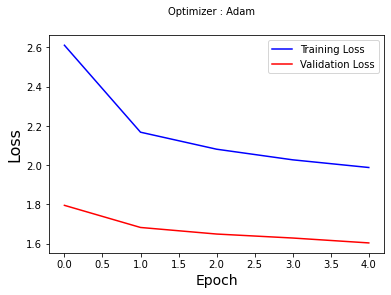

In [117]:
import matplotlib.pyplot as plt
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.plot(hist_adam.history['loss'], color='b', label='Training Loss')
plt.plot(hist_adam.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

Submission 

In [167]:
!mkdir -p saved_model
model.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [168]:
new_model = tf.keras.models.load_model('saved_model/my_model')
new_model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, None, 300)         6000000   
_________________________________________________________________
dropout_38 (Dropout)         (None, None, 300)         0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, None, 500)         450500    
_________________________________________________________________
global_max_pooling1d_19 (Glo (None, 500)               0         
_________________________________________________________________
dropout_39 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 100)               50100     
_________________________________________________________________
dropout_40 (Dropout)         (None, 100)             

In [122]:
x_test_val=np.float32(x_test_val)
x_test_val

array([[0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 5.4000e+01, 1.7000e+01,
        1.8072e+04],
       [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 6.0000e+00, 3.0000e+01,
        2.7300e+02],
       [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 1.4100e+02, 5.6000e+01,
        2.7450e+03],
       ...,
       [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 1.7000e+01, 1.0000e+01,
        8.0000e+00],
       [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 1.0000e+01, 3.4800e+02,
        1.8400e+02],
       [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 1.7000e+01, 1.0000e+01,
        1.4000e+01]], dtype=float32)

In [ ]:
pred1=new_model.predict(x_test_val)

In [124]:
sub=pd.read_csv('dataset/sample_submission.csv',escapechar = "\\",quoting = csv.QUOTE_NONE)

In [125]:
# len(pred1[3])
# train_df=pd.read_csv('dataset/train.csv',escapechar = "\\",quoting = csv.QUOTE_NONE)
# le = LabelEncoder()
# y=le.fit_transform(train_df['BROWSE_NODE_ID'])

In [129]:
pred=[]
for item in range(len(pred1)):
    ind = np.argpartition(pred1[item], -5)[-5:]
    pred.append([ind[np.argsort(pred1[1,ind])][-1]])

In [130]:
pred = [item for sublist in pred for item in sublist]
pred

In [131]:
y=le.inverse_transform(pred)

In [132]:
sub.columns

Index(['PRODUCT_ID', 'BROWSE_NODE_ID'], dtype='object')

In [133]:
len(train_df),len(y)

(2903024, 110775)

In [166]:
d = {'PRODUCT_ID': test_df.PRODUCT_ID, 'BROWSE_NODE_ID': y}
SUBMISSION = pd.DataFrame(data=d)
SUBMISSION

,PRODUCT_ID,BROWSE_NODE_ID
0,1,37666
1,2,2077
2,3,4
3,4,956
4,5,4
...,...,...
110770,110771,4
110771,110772,3928
110772,110773,1313
110773,110774,757


In [135]:
SUBMISSION.to_csv('Submission_final.csv',index=False)